# 

#  <span style="color:lightblue" font="bold"> Baseline Tumor Categorization </span>

## Import Block

In [1]:
### Importing the necessary libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image

## Data Loading and Processing Block

#### 1. <span style="color:lightblue" font="bold"> Loading the dataset </span>

##### 1.2 Loading Paths to images

In [2]:
# Define the path to the classification dataset (relative to the notebook location)
data_dir = Path("../raw_data/classification/BRISC/train")
test_dir = Path("../raw_data/classification/BRISC/test")
os.listdir(data_dir)
os.listdir(test_dir)


['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

#### 1.1 Removing duplicates

In [3]:
from pathlib import Path
import hashlib
import os

# --- Params ---
DATASET_ROOT = Path("../raw_data/classification/BRISC/")  # dossier racine contenant train/ et test/
CLASSES = ["glioma", "pituitary", "meningioma", "notumor"]
SPLITS_ORDER = ["train", "test"] 
EXTENSIONS = (".jpg", ".jpeg", ".png") 
DRY_RUN = False  #  False > réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    for split in SPLITS_ORDER:  # Training d'abord, puis Testing
        for cls in CLASSES:
            folder = DATASET_ROOT / split / cls
            if not folder.exists():
                print(f"⚠️ Dossier absent : {folder}")
                continue
            for ext in EXTENSIONS:
                all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 5950
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
✅ Aucun doublon exact trouvé.


##### 1.3 Creating a dataframe of images paths and labels

In [4]:
# Collect image paths and their corresponding tumor types
image_paths = []
labels = []

for tumor_type in os.listdir(data_dir):
    tumor_type_path = data_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for img_name in os.listdir(tumor_type_path):
            img_path = tumor_type_path / img_name
            # Optional: filter only image files
            if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                image_paths.append(str(img_path))
                labels.append(tumor_type)

# Create a DataFrame for the dataset
df = pd.DataFrame({
    "image_path": image_paths,
    "tumor_type": labels
})

# Show the first few rows for verification
print(df.shape)
df.head(10)


(4962, 2)


,image_path,tumor_type
0,../raw_data/classification/BRISC/train/pituita...,pituitary
1,../raw_data/classification/BRISC/train/pituita...,pituitary
2,../raw_data/classification/BRISC/train/pituita...,pituitary
3,../raw_data/classification/BRISC/train/pituita...,pituitary
4,../raw_data/classification/BRISC/train/pituita...,pituitary
5,../raw_data/classification/BRISC/train/pituita...,pituitary
6,../raw_data/classification/BRISC/train/pituita...,pituitary
7,../raw_data/classification/BRISC/train/pituita...,pituitary
8,../raw_data/classification/BRISC/train/pituita...,pituitary
9,../raw_data/classification/BRISC/train/pituita...,pituitary


#### 2. Label Encoding Tumor Types

In [5]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3}

df["tumor_type_encoded"] = df["tumor_type"].map(mapping)
df.head()

,image_path,tumor_type,tumor_type_encoded
0,../raw_data/classification/BRISC/train/pituita...,pituitary,3
1,../raw_data/classification/BRISC/train/pituita...,pituitary,3
2,../raw_data/classification/BRISC/train/pituita...,pituitary,3
3,../raw_data/classification/BRISC/train/pituita...,pituitary,3
4,../raw_data/classification/BRISC/train/pituita...,pituitary,3


<Axes: xlabel='tumor_type', ylabel='count'>

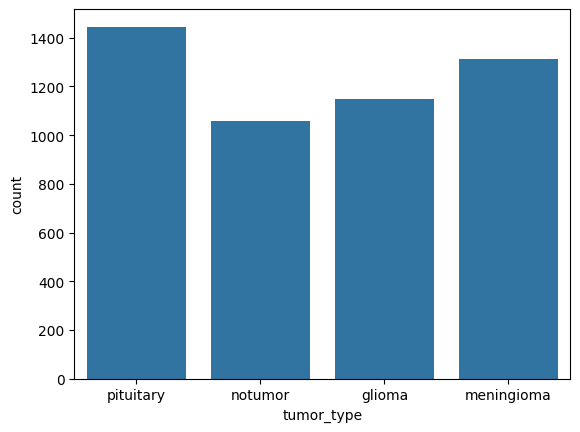

In [6]:
sns.countplot(x="tumor_type", data=df)

#### 3. Preparing the training and validation sets

3.1 Defining data augmentation and processing functions

In [7]:
# Loading images without preprocessing
from tensorflow.lite.python import convert
def load_image(path):
    img = Image.open(path)
    arr = np.array(img, dtype=np.float32)
    return arr

In [8]:
loadtest = load_image(df.image_path[0])
loadtest.shape

(512, 512)

In [9]:
# Load image with processing and data augmentation

# target_size = (224, 224)
# def load_process_image(path, target_size=(224, 224), augment=True):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, target_size)
#     img = tf.cast(img, tf.float32) / 255.0
    
#     if augment:
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
#         img = tf.image.random_brightness(img, max_delta=0.1)
#         img = tf.image.random_contrast(img, 1, 1.1)
        
#     return tf.clip_by_value(img, 0.0, 1.0)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

target_size = (224, 224)
def resnet_preprocess_image(path, target_size=(224, 224), augment=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32)
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=25)
        img = tf.image.random_contrast(img, 0.9, 1.2)
    
    return preprocess_input(img)


3.2 Defining train and val dataframes

Class distribution before split:
0    1058
1    1312
2    1147
3    1445
Name: tumor_type_encoded, dtype: int64

Train set: 3969 samples
Validation set: 993 samples

Class distribution in train set:

Class distribution in validation set:


<Axes: xlabel='tumor_type', ylabel='count'>

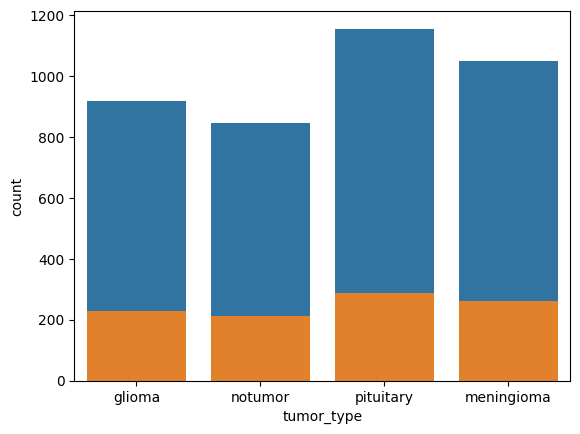

In [11]:
# Split df into train df and validation df
# Verify required column exists
assert "tumor_type_encoded" in df.columns, "Column 'tumor_type_encoded' not found in df"

# Check class distribution before split
print("Class distribution before split:")
print(df["tumor_type_encoded"].value_counts().sort_index())
print()

# Perform stratified split
df_train, df_val = train_test_split(
    df,
    test_size=0.2, 
    stratify=df["tumor_type_encoded"],  # keep class balance
    random_state=42
)

print(f"Train set: {df_train.shape[0]} samples")
print(f"Validation set: {df_val.shape[0]} samples")
print()
print("Class distribution in train set:")
sns.countplot(x="tumor_type", data=df_train)
print()
print("Class distribution in validation set:")
sns.countplot(x="tumor_type", data=df_val)

In [12]:
# Preparing the training dataset

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
paths = df_train["image_path"].values.astype(str)
labels = df_train["tumor_type_encoded"].values.astype("int32")

train_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
train_ds = train_ds.shuffle(len(paths))
train_ds = train_ds.map(
    lambda x, y: (resnet_preprocess_image(x, augment=True), y),
    num_parallel_calls=AUTOTUNE,
)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
print("✅ train_ds created and of type = ", type(train_ds))

✅ train_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


2025-12-04 10:30:32.477108: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-04 10:30:32.477148: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-04 10:30:32.477155: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-12-04 10:30:32.477200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 10:30:32.477228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
val_paths = df_val["image_path"].values.astype(str)
val_labels = df_val["tumor_type_encoded"].values.astype("int32")

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(
    lambda x, y: (resnet_preprocess_image(x, augment=False), y),
    num_parallel_calls=AUTOTUNE,
)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
print("✅ val_ds created and of type = ", type(val_ds))


✅ val_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 4. Preparing the testing  set

In [14]:
# Collect image paths and their corresponding tumor types
from scipy import test


test_paths = []
test_labels = []

for tumor_type in os.listdir(test_dir):
    tumor_type_path = test_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for test_img_name in os.listdir(tumor_type_path):
            test_img_path = tumor_type_path / test_img_name
            # Optional: filter only image files
            if test_img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                test_paths.append(str(test_img_path))
                test_labels.append(tumor_type)

# Create a DataFrame for the dataset
test_df = pd.DataFrame({
    "test_image_path": test_paths,
    "test_tumor_type": test_labels
})

# adding the encoded tumor type
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

test_df["test_tumor_type_encoded"] = test_df["test_tumor_type"].map(mapping)
test_df

,test_image_path,test_tumor_type,test_tumor_type_encoded
0,../raw_data/classification/BRISC/test/pituitar...,pituitary,3
1,../raw_data/classification/BRISC/test/pituitar...,pituitary,3
2,../raw_data/classification/BRISC/test/pituitar...,pituitary,3
3,../raw_data/classification/BRISC/test/pituitar...,pituitary,3
4,../raw_data/classification/BRISC/test/pituitar...,pituitary,3
...,...,...,...
983,../raw_data/classification/BRISC/test/meningio...,meningioma,1
984,../raw_data/classification/BRISC/test/meningio...,meningioma,1
985,../raw_data/classification/BRISC/test/meningio...,meningioma,1
986,../raw_data/classification/BRISC/test/meningio...,meningioma,1


In [15]:
# Preparing the test dataset

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

paths = test_df["test_image_path"].values.astype(str)
labels = test_df["test_tumor_type_encoded"].values.astype("int32")

test_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
test_ds = test_ds.map(
    lambda x, y: (resnet_preprocess_image(x, augment=False), y),
    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

print("✅ test_ds created and of type = ", type(test_ds))

✅ test_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [16]:
# Check the size of train, val and test dataframes
print(f"Train dataframe size: {df_train.shape}")
print(f"Validation dataframe size: {df_val.shape}")
print(f"Test dataframe size: {test_df.shape}")

print("--------------------------------")

# Check sizes of train, val and test datasets
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Train dataframe size: (3969, 3)
Validation dataframe size: (993, 3)
Test dataframe size: (988, 3)
--------------------------------
Train dataset size: 125
Validation dataset size: 32
Test dataset size: 31


## Model Block

In [17]:
# Model input variables
img_size = 224
input_shape = (img_size, img_size, 3)
num_classes = df_train["tumor_type_encoded"].nunique()

print("🔍 Input variables:")
print(f"Number of classes: {num_classes}")
print(f"Input shape: {input_shape}")


🔍 Input variables:
Number of classes: 4
Input shape: (224, 224, 3)


#### 4. Baseline Model Training

##### 4.1 Baseline Initializer and compiler

In [18]:
'''# Baseline model 

def init_baseline(input_shape, num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(128, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Global pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Small dense head
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model'''

"# Baseline model \n\ndef init_baseline(input_shape, num_classes=4):\n    model = Sequential()\n    model.add(Input(shape=input_shape))\n\n    # Block 1\n    model.add(layers.Conv2D(128, (3, 3),\n                            padding='same',\n                            activation='relu'))\n    model.add(layers.MaxPool2D(pool_size=(2, 2)))\n\n    # Block 2\n    model.add(layers.Conv2D(64, (3, 3),\n                            padding='same',\n                            activation='relu'))\n    model.add(layers.MaxPool2D(pool_size=(2, 2)))\n\n    # Global pooling instead of Flatten\n    model.add(layers.GlobalAveragePooling2D())\n\n    # Small dense head\n    model.add(layers.Dropout(0.4))\n    model.add(layers.Dense(32, activation='relu'))\n    model.add(layers.Dropout(0.4))\n    model.add(layers.Dense(num_classes, activation='softmax'))\n\n    return model"

In [19]:
'''
# Model compiler - used for all models 
def compile_baselinemodel(model):
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model
'''

'\n# Model compiler - used for all models \ndef compile_baselinemodel(model):\n    model.compile(optimizer= \'adam\',\n                  loss=\'sparse_categorical_crossentropy\',\n                  metrics=["accuracy"])\n    return model\n'

##### 4.2 Model training

In [20]:
'''
# Model initialization & summary
baseline = init_baseline(input_shape=input_shape, num_classes=4)
baseline.summary()
'''

'\n# Model initialization & summary\nbaseline = init_baseline(input_shape=input_shape, num_classes=4)\nbaseline.summary()\n'

In [21]:
'''
# Model training
baseline = compile_baselinemodel(baseline)
es = EarlyStopping(patience=3, restore_best_weights=True)

    # Set memory growth on all available GPUs
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

history = baseline.fit(train_ds,
                    epochs=5,
                    batch_size=64,
                    validation_data= val_ds,
                    verbose=1,
                    callbacks=[es])
               
'''

'\n# Model training\nbaseline = compile_baselinemodel(baseline)\nes = EarlyStopping(patience=3, restore_best_weights=True)\n\n    # Set memory growth on all available GPUs\nprint("TensorFlow version:", tf.__version__)\nprint(tf.config.list_physical_devices(\'GPU\'))\n\nhistory = baseline.fit(train_ds,\n                    epochs=5,\n                    batch_size=64,\n                    validation_data= val_ds,\n                    verbose=1,\n                    callbacks=[es])\n               \n'

##### 4.3 Model evaluation and confusion matrix

In [22]:
'''results = baseline.evaluate(test_ds, batch_size=32)
results
'''

'results = baseline.evaluate(test_ds, batch_size=32)\nresults\n'

In [23]:
'''from sklearn.metrics import confusion_matrix

# 1. Prédictions
y_proba = baseline.predict(test_ds)
y_pred = np.argmax(y_proba, axis=1)

y_true_batches = []
for _, y_batch in test_ds:
    y_true_batches.append(y_batch.numpy())
y_true = np.concatenate(y_true_batches, axis=0)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tumor_type_labels,
            yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()'''

'from sklearn.metrics import confusion_matrix\n\n# 1. Prédictions\ny_proba = baseline.predict(test_ds)\ny_pred = np.argmax(y_proba, axis=1)\n\ny_true_batches = []\nfor _, y_batch in test_ds:\n    y_true_batches.append(y_batch.numpy())\ny_true = np.concatenate(y_true_batches, axis=0)\n\ncm = confusion_matrix(y_true=y_true, y_pred=y_pred)\n\nplt.figure(figsize=(8, 6))\ntumor_type_labels = [\'notumor\', \'meningioma\', \'glioma\', \'pituitary\']\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues",\n            xticklabels=tumor_type_labels,\n            yticklabels=tumor_type_labels)\nplt.xlabel("Predicted")\nplt.ylabel("True")\nplt.title("Confusion Matrix")\nplt.show()'

#### 5. Transfer learning with ResNet

##### 5.1 Base ResNet model (no fine-tuning) initializer

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


def init_resnet():
    
    resnet = ResNet50(input_shape=input_shape, 
                            weights='imagenet', 
                            include_top=False)

    for layer in resnet.layers:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)

    return model
    

In [ ]:
# Model compiler - used for all models 
from tensorflow.keras.optimizers import Adam
def compile_model(model):
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [52]:
model = init_resnet()
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                           

##### 5.2 Model training

In [44]:
model = compile_model(model)
es = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=30, 
                        callbacks=es)

Epoch 1/30


2025-12-04 10:42:26.717990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


125/125 [==============================] - 37s 280ms/step - loss: 4.3840 - accuracy: 0.2451 - val_loss: 1.7217 - val_accuracy: 0.2588
Epoch 2/30
125/125 [==============================] - 33s 262ms/step - loss: 3.9646 - accuracy: 0.2716 - val_loss: 1.4823 - val_accuracy: 0.3394
Epoch 3/30
125/125 [==============================] - 24s 191ms/step - loss: 3.9464 - accuracy: 0.2895 - val_loss: 1.3233 - val_accuracy: 0.4109
Epoch 4/30
125/125 [==============================] - 24s 191ms/step - loss: 3.8692 - accuracy: 0.2976 - val_loss: 1.1988 - val_accuracy: 0.4693
Epoch 5/30
125/125 [==============================] - 24s 190ms/step - loss: 3.7257 - accuracy: 0.3210 - val_loss: 1.0849 - val_accuracy: 0.5337
Epoch 6/30
125/125 [==============================] - 24s 191ms/step - loss: 3.6315 - accuracy: 0.3283 - val_loss: 1.0103 - val_accuracy: 0.5690
Epoch 7/30
125/125 [==============================] - 24s 193ms/step - loss: 3.5361 - accuracy: 0.3376 - val_loss: 0.9436 - val_accuracy: 0.5

In [45]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print(classification_report(y_true, y_pred_classes, 
                          target_names=['notumor', 'meningioma', 'glioma', 'pituitary']))

32/32 [==============================] - 7s 216ms/step
              precision    recall  f1-score   support

     notumor       0.91      0.89      0.90       212
  meningioma       0.72      0.68      0.70       263
      glioma       0.85      0.67      0.75       229
   pituitary       0.77      0.96      0.86       289

    accuracy                           0.80       993
   macro avg       0.81      0.80      0.80       993
weighted avg       0.81      0.80      0.80       993



##### 5.3 Model evaluation and confusion matrix

In [46]:
results_inc = model.evaluate(test_ds, batch_size=32)
results_inc

31/31 [==============================] - 7s 236ms/step - loss: 0.7213 - accuracy: 0.7338


[0.7213039994239807, 0.7338056564331055]

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

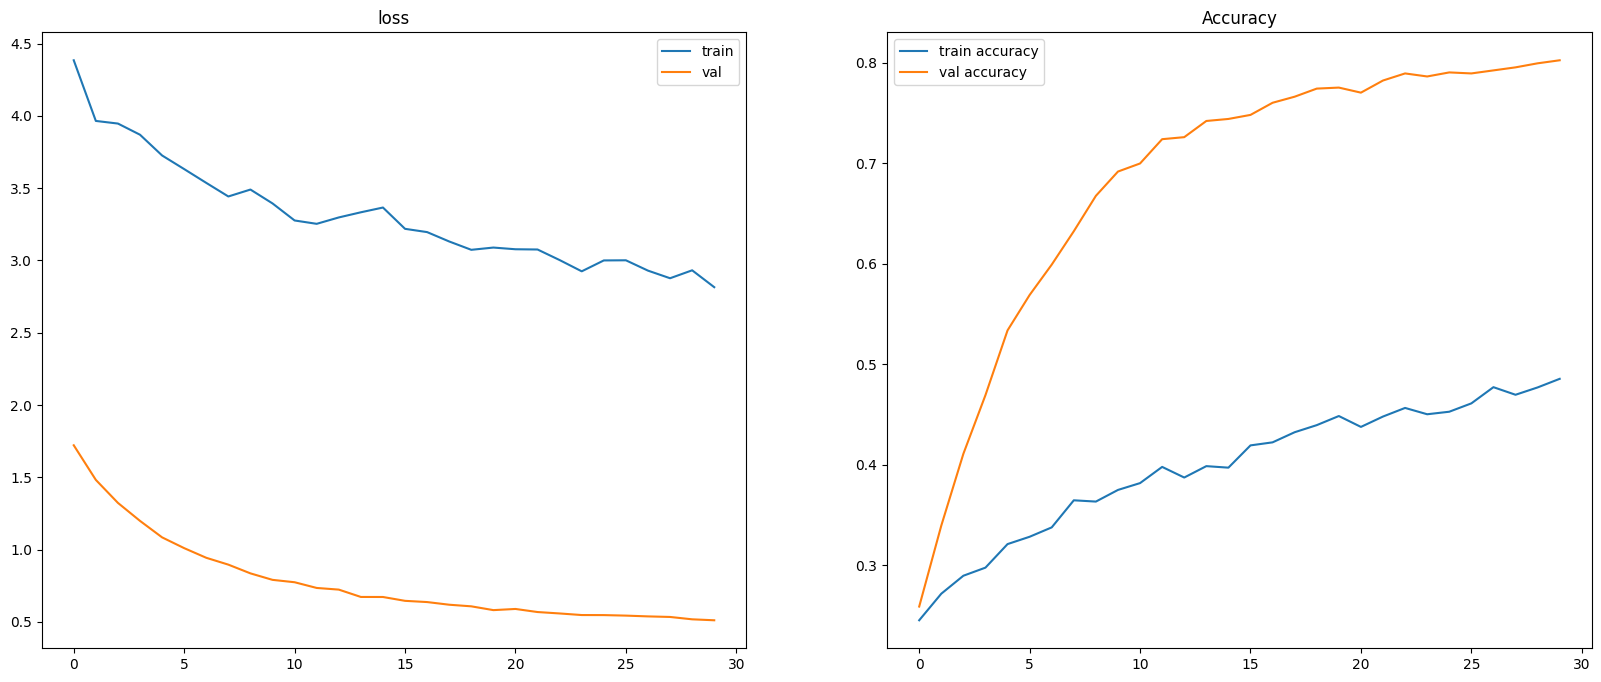

In [47]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history)

In [48]:
y_pred = model.predict(test_ds)

31/31 [==============================] - 7s 231ms/step


In [49]:
y_pred = np.argmax(y_pred, axis=1)

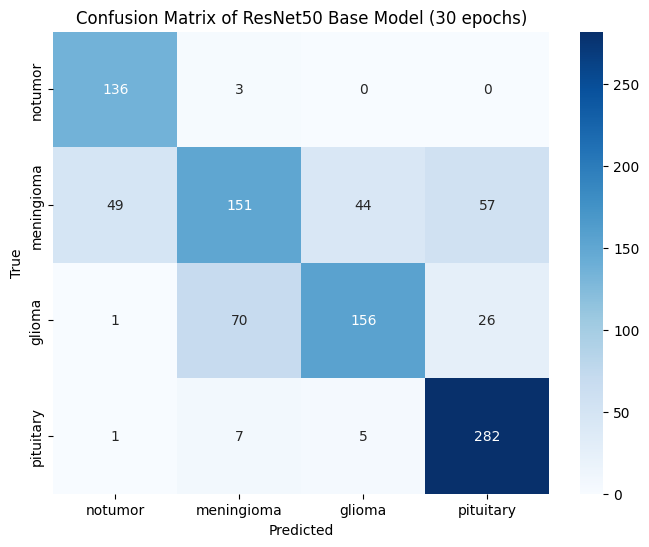

In [50]:
from sklearn.metrics import confusion_matrix


y_true_batches = []
for _, y_batch in test_ds:
    y_true_batches.append(y_batch.numpy())
y_true = np.concatenate(y_true_batches, axis=0)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tumor_type_labels,
            yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of ResNet50 Base Model (30 epochs)")
plt.show()

#### 5.4 ResNet Model Fine-tuning

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model = model.get_layer('resnet50')  

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-10:]:     
    layer.trainable = True

# Re-compiler avec un LR plus petit
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                             

In [35]:
'''
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[es],
)
 '''

'\nhistory_ft = model.fit(\n    train_ds,\n    validation_data=val_ds,\n    epochs=10,\n    callbacks=[es],\n)\n '